In [1]:
import torch
from torch import Tensor

from math import cos

In [2]:
mic_dist = torch.arange(0, 6, 1)*0.02 # torch.tensor([-0.037, 0, 0.124])
c = 340
look_dir = 0 # torch.pi/3
freq = torch.arange(0, 1025) * 48000 / 2048
freq_bin_size = 48000/2048

In [3]:
d = torch.exp(-1j * 2*torch.pi*freq.unsqueeze(1) * mic_dist.unsqueeze(0) / c * cos(look_dir))

In [4]:
d.size()

torch.Size([1025, 6])

In [5]:
c_dn = torch.sinc((mic_dist.view(1, -1, 1) - mic_dist.view(1, 1, -1)) * 2*freq.view(-1, 1, 1)/c)   # torch.sinc: sin(pi*x)/(pi*x)

# Fixed Beamformer

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
dn = torch.linalg.inv(0.99*c_dn + torch.eye(c_dn.size(1)).unsqueeze(0)*0.01)
dn = torch.complex(dn, torch.zeros_like(dn))
fixed_beamformer = (dn*d.unsqueeze(1)).sum(2) / (d.conj().unsqueeze(2) * dn * d.unsqueeze(1)).sum((1, 2)).unsqueeze(1)

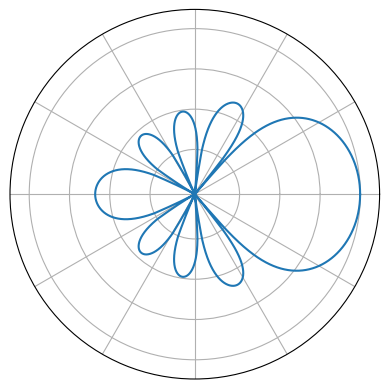

In [8]:
view_freq = 4000
freq_idx = round(view_freq / freq_bin_size)

theta = torch.deg2rad(torch.arange(0, 360, 0.1).unsqueeze(0))
directions = torch.exp(-1j * 2*torch.pi*view_freq * mic_dist.unsqueeze(1) / c * torch.cos(theta))    # [#mic, theta]

amp = (directions * fixed_beamformer[freq_idx].unsqueeze(1).conj()).sum(0)
amp = amp.abs()**2

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_rscale('symlog', linthresh=0.001)
ax.set_xticks(np.arange(0, np.pi*2, np.pi / 6))
ax.set_ylim([0, 3])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_rmax(1)
# ax.set_rticks([0, 1.e-3, 1.e-2, 1.e-1, 1])
ax.plot(theta.squeeze().numpy(), amp.numpy())

# functions for primary and secondary beamformer

In [9]:
def bisec(f, start, end, size, eps = 1e-8):
    start = torch.ones(size, 1)*start
    end = torch.ones(size, 1)*end
    med = (start + end) / 2
    fm = f(med)
    
    i = 0
    while (abs(fm) > eps).any():
        start[fm > 0] = med[fm > 0]
        end[fm < 0] = med[fm < 0]
        med = (start + end) / 2
        fm = f(med)
        i += 1
        
        if i > 10000:
            break
    
    return (start + end)/2

In [10]:
def criterion_solver1(A: Tensor, d: Tensor, rho: float = 1.e2) -> Tensor:
    """criterion solver for primary and secondary beamformer

    Args:
        A (Tensor): [F, #mic, #mic]
        d (Tensor): [F, #mic]
        rho (float, optional): rho_WNG

    Returns:
        h: [F, #mic]
    """
    L, U = torch.linalg.eig(A)
    a = (U.conj()*d.unsqueeze(2)).sum(1)
    a = (a * a.conj()).real     # [F, #mic]
    
    def f(eps):
        l_eps = L + eps
        numerator = (a / (l_eps * l_eps.conj())).sum(-1)
        denominator = (a / (L + eps)).sum(-1)
        denominator = denominator * denominator.conj()
        return (numerator / denominator).real - rho
    
    eps = bisec(f, 0., 100., a.size(0))
    
    Ae = A + torch.eye(A.size(1)).unsqueeze(0) * eps.view(-1, 1, 1)
    Ae_inv = torch.linalg.inv(Ae[1:])
    Ae_inv = torch.cat([torch.linalg.pinv(Ae[0]).unsqueeze(0), Ae_inv], dim=0)
    if not torch.is_complex(Ae_inv):
        Ae_inv = torch.complex(Ae_inv, torch.zeros_like(Ae_inv))
    
    numerator = (Ae_inv * d.unsqueeze(1)).sum(2)
    denominator = (d.conj().unsqueeze(2) * Ae_inv * d.unsqueeze(1)).sum((1, 2)).unsqueeze(1)
    h = numerator / denominator
    
    
    return h

# Primary Beamformer

In [11]:
primary_beamformer = criterion_solver1(c_dn, d, rho=1.e2)

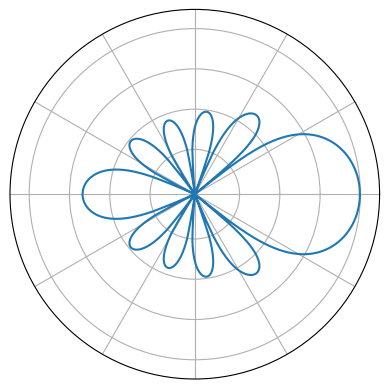

In [12]:
view_freq = 4000
freq_idx = round(view_freq / freq_bin_size)

theta = torch.deg2rad(torch.arange(0, 360, 0.1).unsqueeze(0))
directions = torch.exp(-1j * 2*torch.pi*view_freq * mic_dist.unsqueeze(1) / c * torch.cos(theta))    # [#mic, theta]

amp = (directions * primary_beamformer[freq_idx].unsqueeze(1).conj()).sum(0)
amp = amp.abs()**2

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_rscale('symlog', linthresh=0.001)
ax.set_xticks(np.arange(0, np.pi*2, np.pi / 6))
ax.set_ylim([0, 3])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_rmax(1)
ax.plot(theta.squeeze().numpy(), amp.numpy())

# Secondary Beamformer

In [13]:
psi = torch.zeros(freq.size(0), mic_dist.size(0), mic_dist.size(0)) * 1j

for i in range(mic_dist.size(0)):
    for j in range(mic_dist.size(0)):
        g = torch.sinc(abs(mic_dist.view(1, -1, 1) - mic_dist.view(1, 1, -1) + mic_dist[i] - mic_dist[j]) * 2*freq.view(-1, 1, 1)/c)
        g = torch.complex(g, torch.zeros_like(g))
        psi[:, i, j] = (primary_beamformer.conj().unsqueeze(2) * g * primary_beamformer.unsqueeze(1)).sum((1, 2))

In [14]:
secondary_beamformer = criterion_solver1(psi, d, rho=1.e2)

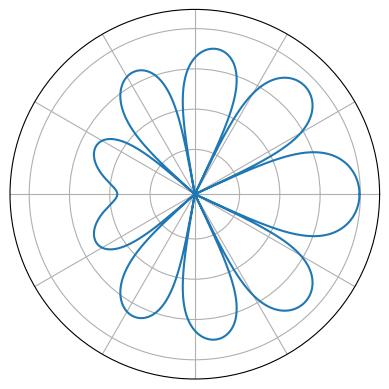

In [15]:
view_freq = 4000
freq_idx = round(view_freq / freq_bin_size)

theta = torch.deg2rad(torch.arange(0, 360, 0.1).unsqueeze(0))
directions = torch.exp(-1j * 2*torch.pi*view_freq * mic_dist.unsqueeze(1) / c * torch.cos(theta))    # [#mic, theta]

amp = (directions * secondary_beamformer[freq_idx].unsqueeze(1).conj()).sum(0)
amp = amp.abs()**2

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_rscale('symlog', linthresh=0.001)
ax.set_xticks(np.arange(0, np.pi*2, np.pi / 6))
ax.set_ylim([0, 3])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_rmax(1)
ax.plot(theta.squeeze().numpy(), amp.numpy())

# Function for auxiliary beamformer

In [16]:
def criterion_solver2(D: Tensor, b: Tensor, rho: float=1.e2) -> Tensor:
    """_summary_

    Args:
        D (Tensor): [F, #mic, angle]
        b (Tensor): [F, angle]
        rho (float, optional): rho_WNG. Defaults to 1.e2.

    Returns:
        Tensor: [F, #mic]
    """
    f = D.size(0)
    DD = torch.bmm(D, D.transpose(1, 2).conj())
    L, U = torch.linalg.eig(DD)
    a = (U.conj().unsqueeze(3) * D.unsqueeze(2) * b.conj().view(f, 1, 1, -1)).sum((1, 3))
    a = (a * a.conj()).real
    
    def g(eps):
        l_eps = L + eps
        den = l_eps * l_eps.conj()
        return (a / den).sum().real - rho

    eps = bisec(g, 0, 100, size = L.size(0))
    
    De = DD + eps.view(-1, 1, 1)*torch.eye(D.size(1)).unsqueeze(0)
    inv_mat = torch.linalg.inv(De[1:])
    inv_mat = torch.cat([torch.linalg.pinv(De[0]).unsqueeze(0), inv_mat], dim=0)
    if not torch.is_complex(inv_mat):
        inv_mat = torch.complex(inv_mat, torch.zeros_like(inv_mat))
    h = (inv_mat.unsqueeze(3) * D.unsqueeze(1) * b.conj().view(f, 1, 1, -1)).sum((2, 3))
    
    return h

# Auxiliary Beamformer

In [17]:
aux_beamformers = [primary_beamformer, secondary_beamformer]

theta = torch.deg2rad(torch.arange(0, 360, 0.1)).view(1, 1, -1)
D = torch.exp(-1j * 2*torch.pi*freq.view(-1, 1, 1) * mic_dist.view(1, -1, 1) / c * torch.cos(theta))    # [F, #mic, angle]

B_sum = (D * primary_beamformer.conj().unsqueeze(2)).sum(1).abs()**2
B_sum = B_sum + (D * secondary_beamformer.conj().unsqueeze(2)).sum(1).abs()**2

In [18]:
for i in range(2, 9):
    B_max = B_sum.max(1, keepdim=True)[0]
    b = torch.sqrt(B_max - B_sum)
    b = torch.complex(b, torch.zeros_like(b))
    
    beamformer = criterion_solver2(D, b, 1e2)
    aux_beamformers.append(beamformer)
    
    B_sum = B_sum + (D * beamformer.conj().unsqueeze(2)).sum(1).abs()**2

In [19]:
B_max = B_sum.max(1, keepdim=True)[0]
aux_beamformers = [bf/torch.sqrt(B_max) for bf in aux_beamformers]

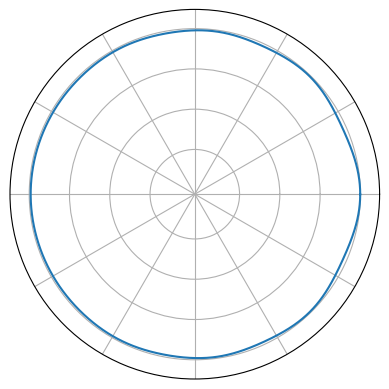

In [20]:
view_freq = 4000
freq_idx = round(view_freq / freq_bin_size)

theta = torch.deg2rad(torch.arange(0, 360, 0.1).unsqueeze(0))
directions = torch.exp(-1j * 2*torch.pi*view_freq * mic_dist.unsqueeze(1) / c * torch.cos(theta))    # [#mic, theta]

amp = 0
for bf in aux_beamformers:
    amp = amp + (directions * bf[freq_idx].unsqueeze(1).conj()).sum(0).abs()**2

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_rscale('symlog', linthresh=0.001)
ax.set_xticks(np.arange(0, np.pi*2, np.pi / 6))
ax.set_ylim([0, 3])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.plot(theta.squeeze().numpy(), amp.numpy())

# Directional Gain

In [21]:
theta = torch.deg2rad(torch.arange(0, 360, 0.1))
full_d = torch.exp(-1j * 2*torch.pi*freq.view(-1, 1, 1) * mic_dist.view(1, -1, 1) / c * torch.cos(theta.view(1, 1, -1)))

In [22]:
pbr = 40     # point source to background noise ratio
pbr = 10**(pbr/10)
YY = pbr * (full_d.unsqueeze(2) * full_d.conj().unsqueeze(1)) + (0.99*c_dn + 0.01*torch.eye(mic_dist.size(0)).unsqueeze(0)).unsqueeze(-1)
# YY: [F, m, m, angle]

In [23]:
f = freq.size(0)
m = mic_dist.size(0)

In [24]:
numer = (primary_beamformer.conj().view(f, m, 1, 1) * YY * secondary_beamformer.view(f, 1, m, 1)).sum((1, 2))
denomi = 0.
for bf in aux_beamformers:
    denomi = denomi + (bf.conj().view(f, m, 1, 1) * YY * bf.view(f, 1, m, 1)).sum((1, 2))

In [25]:
gain = numer / denomi

In [26]:
G = gain.real
# G = G - G.min()
G[G < 0] = 0
G[G > 1] = 1

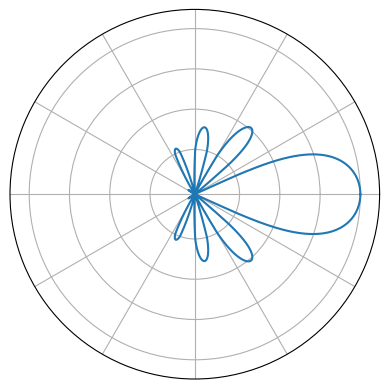

In [27]:
view_freq = 4000
freq_idx = round(view_freq / freq_bin_size)

# theta = torch.deg2rad(torch.arange(0, 360, 0.1).unsqueeze(0))
# directions = torch.exp(-1j * 2*torch.pi*view_freq * mic_dist.unsqueeze(1) / c * torch.cos(theta))    # [#mic, theta]

amp = G[freq_idx]**2

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_rscale('symlog', linthresh=0.001)
ax.set_xticks(np.arange(0, np.pi*2, np.pi / 6))
ax.set_ylim([0, 3])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.plot(theta.squeeze().numpy(), amp.numpy())

# Global Beamformer

In [28]:
final_bf = fixed_beamformer.unsqueeze(-1) * G.unsqueeze(1)

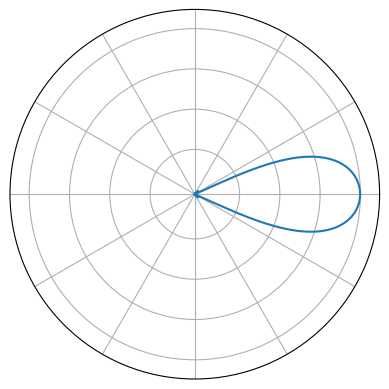

In [29]:
view_freq = 4000
freq_idx = round(view_freq / freq_bin_size)

theta = torch.deg2rad(torch.arange(0, 360, 0.1).unsqueeze(0))
directions = torch.exp(-1j * 2*torch.pi*view_freq * mic_dist.unsqueeze(1) / c * torch.cos(theta))    # [#mic, theta]

amp = (directions * final_bf[freq_idx].conj()).sum(0).abs()**2

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_rscale('symlog', linthresh=0.001)
ax.set_xticks(np.arange(0, np.pi*2, np.pi / 6))
ax.set_ylim([0, 3])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.plot(theta.squeeze().numpy(), amp.numpy())